In [23]:
import uproot
import matplotlib.pyplot as plt
import numpy as np
import h5py
import seaborn as sb
from sklearn.model_selection import train_test_split
from sklearn.metrics import multilabel_confusion_matrix
from sklearn.metrics import precision_score, accuracy_score

In [2]:
f_TRN = uproot.open('/mnt/xrootdg/jchishol/mntuples_08_01_22/Results/TRecNet_6jets_20230525_111504_nominal_Results.root')

In [7]:
eta_reco = f_TRN['reco/th_eta'].array()
eta_parton = f_TRN['parton/th_eta'].array()
pt_reco = f_TRN['reco/th_pt'].array()
pt_parton = f_TRN['parton/th_pt'].array()

In [10]:
pt_res = (pt_reco - pt_parton)/pt_parton
eta_res = eta_reco - eta_parton

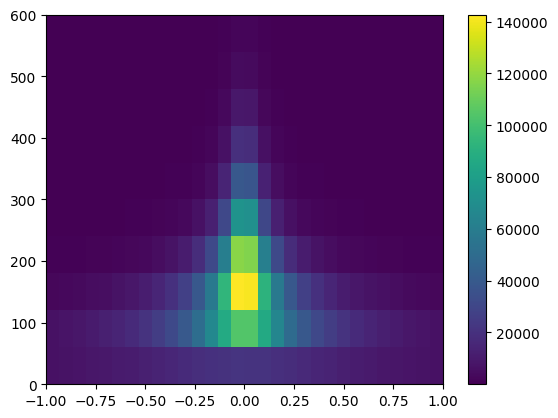

In [70]:
plt.hist2d(eta_res,pt_parton,bins=np.array([30,10]), range=np.array([(-1,1),(0,600)]));
plt.colorbar()

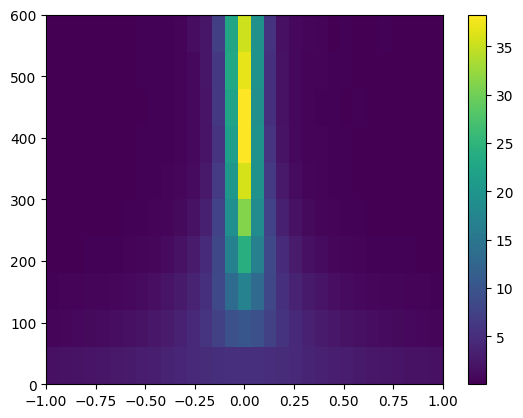

In [79]:
H, xedges, yedges = np.histogram2d(eta_res,pt_parton,bins=np.array([31,10]), range=np.array([(-1,1),(0,600)]))
#print(H)
#print(H.T)
#print(np.sum(H,axis=0))
#Hmasked = np.ma.masked_where(H==0,H)
#print(Hmasked)
#H_norm_rows = (H.T/np.sum(H.T,axis=1))
H_norm_rows = np.divide(H,np.sum(H,axis=0)).T*100
#print(H_norm_rows)
plt.pcolormesh(xedges,yedges,H_norm_rows)
plt.colorbar()

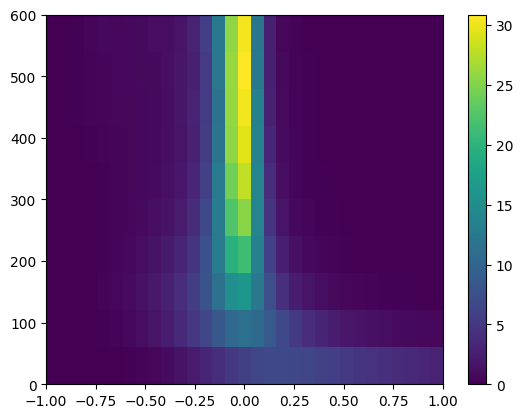

In [78]:
H, xedges, yedges = np.histogram2d(pt_res,pt_parton,bins=np.array([31,10]), range=np.array([(-1,1),(0,600)]))
#print(H)
#print(H.T)
#print(np.sum(H,axis=0))
#Hmasked = np.ma.masked_where(H==0,H)
#print(Hmasked)
#H_norm_rows = (H.T/np.sum(H.T,axis=1))
H_norm_rows = np.divide(H,np.sum(H,axis=0)).T*100
#print(H_norm_rows)
plt.pcolormesh(xedges,yedges,H_norm_rows)
plt.colorbar()

In [ ]:
f_test = h5py.File("/mnt/xrootdg/jchishol/mntuples_08_01_22/variables_ttbar_ljets_10j_test.h5",'r')
eventnumbers = np.array(f_test.get('eventNumber'))
print(eventnumbers)

[  7040187   7038749   7038156 ... 256311943 256310852 256311272]


In [2]:
from MLUtil import *
processor = Utilities()

2023-08-16 12:32:00.468633: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-16 12:32:00.468746: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [4]:
# Load the models
hyp_model = keras.models.load_model('TRecNet/TRecNet_6jets_20230524_144557/TRecNet_6jets_20230524_144557.keras')
og_model = keras.models.load_model('TRecNet/TRecNet_6jets_20230525_111504/TRecNet_6jets_20230525_111504.keras')

2023-08-14 11:09:52.296480: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-14 11:09:52.296624: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-08-14 11:09:52.296709: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2023-08-14 11:09:52.296796: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2023-08-14 11:09:52.296886: W tensorflow/stream_executor/platform/default/dso_loader.cc:64

In [5]:
# These are the keys for what we're feeding into the pre-processing, and getting back in the end
# X and Y variables to be used (NOTE: later have option to feed these in?)
X_keys, Y_keys = processor.getInputKeys('TRecNet', 6)

# Load maxmean
X_maxmean_dic, Y_maxmean_dic = processor.loadMaxMean('/mnt/xrootdg/jchishol/mntuples_08_01_22/X_maxmean_variables_ttbar_ljets_10j_train.npy', '/mnt/xrootdg/jchishol/mntuples_08_01_22/Y_maxmean_variables_ttbar_ljets_10j_train.npy')

# Pre-process the data
totalX_jets, totalX_other, totalY, X_scaled_keys, Y_scaled_keys = processor.prepData('/mnt/xrootdg/jchishol/mntuples_08_01_22/variables_ttbar_ljets_10j_train.h5', X_maxmean_dic, Y_maxmean_dic, X_keys, Y_keys, 6, -2)

# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
split = 70/85   # Gave 85% to train file, now want 70% for the actual training
_, valX_jets, _, valX_other, _, valY = train_test_split(totalX_jets, totalX_other, totalY, train_size=split)


Preparing data...


In [ ]:
true_scaled = valY 

# Hyp predictions
hyp_preds_scaled = hyp_model.predict([valX_jets, valX_other])

# Org predictions
og_preds_scaled = og_model.predict([valX_jets, valX_other])


# Invert scaling
scaler = normalize_new.Scaler()
hyp_preds_origscale_dic = scaler.invscale_arrays(hyp_preds_scaled, Y_scaled_keys, Y_maxmean_dic)
og_preds_origscale_dic = scaler.invscale_arrays(og_preds_scaled, Y_scaled_keys, Y_maxmean_dic)
true_origscale_dic = scaler.invscale_arrays(true_scaled, Y_scaled_keys, Y_maxmean_dic)

113002/113002 [==============================] - 461s 4ms/step


In [ ]:
ticks_size = 10
axis_size = 12
legend_size = 10
nbins = 30

In [ ]:
hyp_preds = hyp_preds_origscale_dic['th_phi']
og_preds = og_preds_origscale_dic['th_phi']
truths = true_origscale_dic['th_phi']

max_val = max(max(hyp_preds), max(og_preds), max(truths))
min_val = min(min(hyp_preds), min(og_preds), min(truths))

# Plot histograms of true and reco results on the same histogram
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex=True,gridspec_kw={'height_ratios': [4, 1]})
hyp_reco_n, bins, _ = ax1.hist(hyp_preds,bins=nbins,range=(min_val, max_val),histtype='step',label='Prediction (Hypertuned)')
og_reco_n, bins, _ = ax1.hist(og_preds,bins=nbins,range=(min_val, max_val),histtype='step',label='Prediction (Original)')
truth_n, _, _ = ax1.hist(truths,bins=nbins,range=(min_val, max_val),histtype='step',label='Truth')

# Plot the ratio of the two histograms underneath (with a dashed line at 1)
x_dash,y_dash = np.linspace(min_val,max_val,100),[1]*100
ax2.plot(x_dash,y_dash,'--',color='tab:green')
bin_width = np.diff(bins)
ax2.hist(bins[:-1], bins, weights=truth_n/hyp_reco_n-1, histtype='step',bottom=1)  # Using bin width so points are plotting aligned with middle of the bin
ax2.hist(bins[:-1], bins, weights=truth_n/og_reco_n-1, histtype='step',bottom=1)  # Using bin width so points are plotting aligned with middle of the bin
ax2.set(ylim=(0.8, 1.2))

ax2.set_xlabel('$\phi^{t,had}$', fontsize=axis_size)
ax1.set_ylabel('Events', fontsize=axis_size)
ax2.set_ylabel(r'$\dfrac{\mathrm{Truth}}{\mathrm{Prediction}}$', fontsize=axis_size)
ax1.legend(fontsize=legend_size,loc='lower right')

plt.savefig("TRecNet_val_th_phi",bbox_inches='tight')

In [ ]:
hyp_preds = hyp_preds_origscale_dic['tl_phi']
og_preds = og_preds_origscale_dic['tl_phi']
truths = true_origscale_dic['tl_phi']

max_val = max(max(hyp_preds), max(og_preds), max(truths))
min_val = min(min(hyp_preds), min(og_preds), min(truths))

# Plot histograms of true and reco results on the same histogram
fig, (ax1, ax2) = plt.subplots(nrows=2,sharex=True,gridspec_kw={'height_ratios': [4, 1]})
hyp_reco_n, bins, _ = ax1.hist(hyp_preds,bins=nbins,range=(min_val, max_val),histtype='step',label='Prediction (Hypertuned)')
og_reco_n, bins, _ = ax1.hist(og_preds,bins=nbins,range=(min_val, max_val),histtype='step',label='Prediction (Original)')
truth_n, _, _ = ax1.hist(truths,bins=nbins,range=(min_val, max_val),histtype='step',label='Truth')

# Plot the ratio of the two histograms underneath (with a dashed line at 1)
x_dash,y_dash = np.linspace(min_val,max_val,100),[1]*100
ax2.plot(x_dash,y_dash,'--',color='tab:green')
bin_width = np.diff(bins)
ax2.hist(bins[:-1], bins, weights=truth_n/hyp_reco_n-1, histtype='step',bottom=1)  # Using bin width so points are plotting aligned with middle of the bin
ax2.hist(bins[:-1], bins, weights=truth_n/og_reco_n-1, histtype='step',bottom=1)  # Using bin width so points are plotting aligned with middle of the bin
ax2.set(ylim=(0.9, 1.1))

ax2.set_xlabel('$\phi^{t,lep}$', fontsize=axis_size)
ax1.set_ylabel('Events', fontsize=axis_size)
ax2.set_ylabel(r'$\dfrac{\mathrm{Truth}}{\mathrm{Prediction}}$', fontsize=axis_size)
ax1.legend(fontsize=legend_size,loc='lower right')

plt.savefig("TRecNet_val_tl_phi",bbox_inches='tight')

In [3]:
from MLUtil import *
processor = Utilities()

jet_model = keras.models.load_model('JetPretrainer/JetPretrainer_6jets_20230530_112415/JetPretrainer_6jets_20230530_112415.keras')

# These are the keys for what we're feeding into the pre-processing, and getting back in the end
# X and Y variables to be used (NOTE: later have option to feed these in?)
X_keys, Y_keys = processor.getInputKeys('JetPretrainer', 6)

# Load maxmean
X_maxmean_dic, Y_maxmean_dic = processor.loadMaxMean('/mnt/xrootdg/jchishol/mntuples_08_01_22/X_maxmean_variables_ttbar_ljets_10j_train.npy', '/mnt/xrootdg/jchishol/mntuples_08_01_22/Y_maxmean_variables_ttbar_ljets_10j_train.npy')

# Pre-process the data
totalX_jets, totalX_other, totalY, X_scaled_keys, Y_scaled_keys = processor.prepData('/mnt/xrootdg/jchishol/mntuples_08_01_22/variables_ttbar_ljets_10j_train.h5', X_maxmean_dic, Y_maxmean_dic, X_keys, Y_keys, 6, -2)

# Set how the data will be split (70 for training, 15 for validation, 15 for testing)
split = 70/85   # Gave 85% to train file, now want 70% for the actual training
_, valX_jets, _, valX_other, _, valY = train_test_split(totalX_jets, totalX_other, totalY, train_size=split)

2023-08-25 12:52:20.712861: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-25 12:52:20.712904: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-08-25 12:52:23.083881: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-08-25 12:52:23.084008: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2023-08-25 12:52:23.084084: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: lib

Preparing data...


In [4]:
true_scaled = valY 

# Jet predictions
jet_preds_scaled = jet_model.predict([valX_jets, valX_other])

# Invert scaling
#scaler = normalize_new.Scaler()
#jet_preds_origscale_dic = scaler.invscale_arrays(jet_preds_scaled, Y_scaled_keys, Y_maxmean_dic)
#true_origscale_dic = scaler.invscale_arrays(true_scaled, Y_scaled_keys, Y_maxmean_dic)

113002/113002 [==============================] - 147s 1ms/step


[[[ 542349  183921]
  [  81125 2808641]]

 [[ 405812  231919]
  [ 100121 2878184]]

 [[ 511886  324037]
  [ 134776 2645337]]

 [[ 884140  370175]
  [ 255194 2106527]]

 [[2482568  189164]
  [ 204706  739598]]

 [[3239091   69832]
  [ 112779  194334]]]
2808641
j1 Accuracy:  0.9267026102616235
j1 Precision:  0.9385406217147715
2878184
j2 Accuracy:  0.9081756929411101
j2 Precision:  0.9254304439434964
2645337
j3 Accuracy:  0.8731171371081483
j3 Precision:  0.8908736319507075
2106527
j4 Accuracy:  0.8270567549659351
j4 Precision:  0.8505371255807118
739598
j5 Accuracy:  0.8910768587480877
j5 Precision:  0.796326723100213
194334
j6 Accuracy:  0.9494996731227233
j6 Precision:  0.7356510678891304


/tmp/ipykernel_895090/1204792813.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


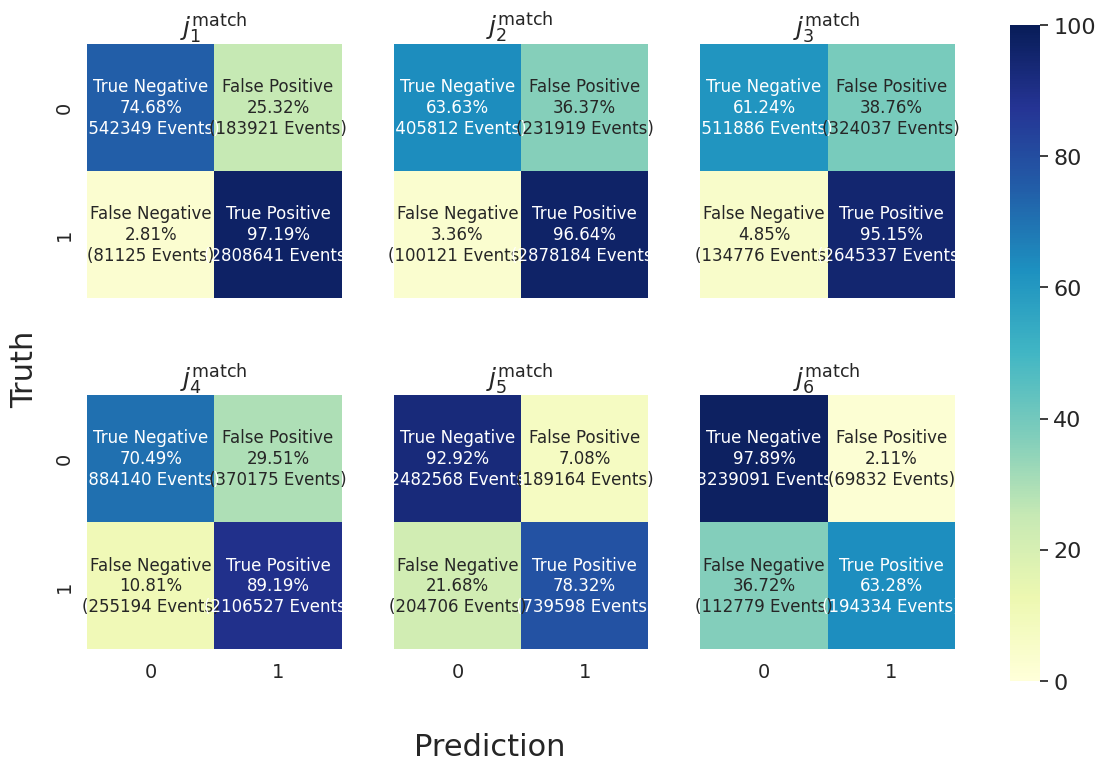

In [27]:
%matplotlib inline
cms = multilabel_confusion_matrix(np.array(true_scaled), np.array(jet_preds_scaled).round())
print(cms)

fig, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=(10, 8))
cbar_ax = fig.add_axes([1.02, .11, .03, .82])

jet = 0
for i in range(2):
    for j in range(3):
        cm = cms[jet]
        print(cm[1][1])
        group_names = ['True Negative','False Positive','False Negative','True Positive']
        group_counts = ["({0:0.0f} Events)".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm[0].flatten()/np.sum(cm[0])]
        group_percentages.extend(["{0:.2%}".format(value) for value in cm[1].flatten()/np.sum(cm[1])])
        labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_percentages, group_counts)]
        labels = np.asarray(labels).reshape(2,2)
        normed = [cm[0]*100/np.sum(cm[0]),cm[1]*100/np.sum(cm[1])]
        sub = sb.heatmap(normed,vmin=0, vmax=100, cmap='YlGnBu',fmt='',annot=labels, cbar=True, cbar_ax=cbar_ax,square=True, ax=ax[i,j])
        sb.set(font_scale=1)
        sub.figure.axes[-1].tick_params(labelsize=16)
        ax[i,j].set_title('$j_%d^{\mathrm{match}}$ '% (jet+1), fontsize=18)
        ax[i,j].tick_params(left=False,bottom=False, labelsize=14) 
        
        print('j'+str(jet+1)+' Accuracy: ',accuracy_score(true_scaled[:,jet],jet_preds_scaled.round()[:,jet]))
        print('j'+str(jet+1)+' Precision: ',precision_score(true_scaled[:,jet],jet_preds_scaled.round()[:,jet]))
        
        jet+=1


fig.supxlabel('Prediction',fontsize=22)
fig.supylabel('Truth',fontsize=22)
fig.tight_layout()

[[[ 542349  183921]
  [  81125 2808641]]

 [[ 405812  231919]
  [ 100121 2878184]]

 [[ 511886  324037]
  [ 134776 2645337]]

 [[ 884140  370175]
  [ 255194 2106527]]

 [[2482568  189164]
  [ 204706  739598]]

 [[3239091   69832]
  [ 112779  194334]]]


/tmp/ipykernel_895090/2509742434.py:34: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


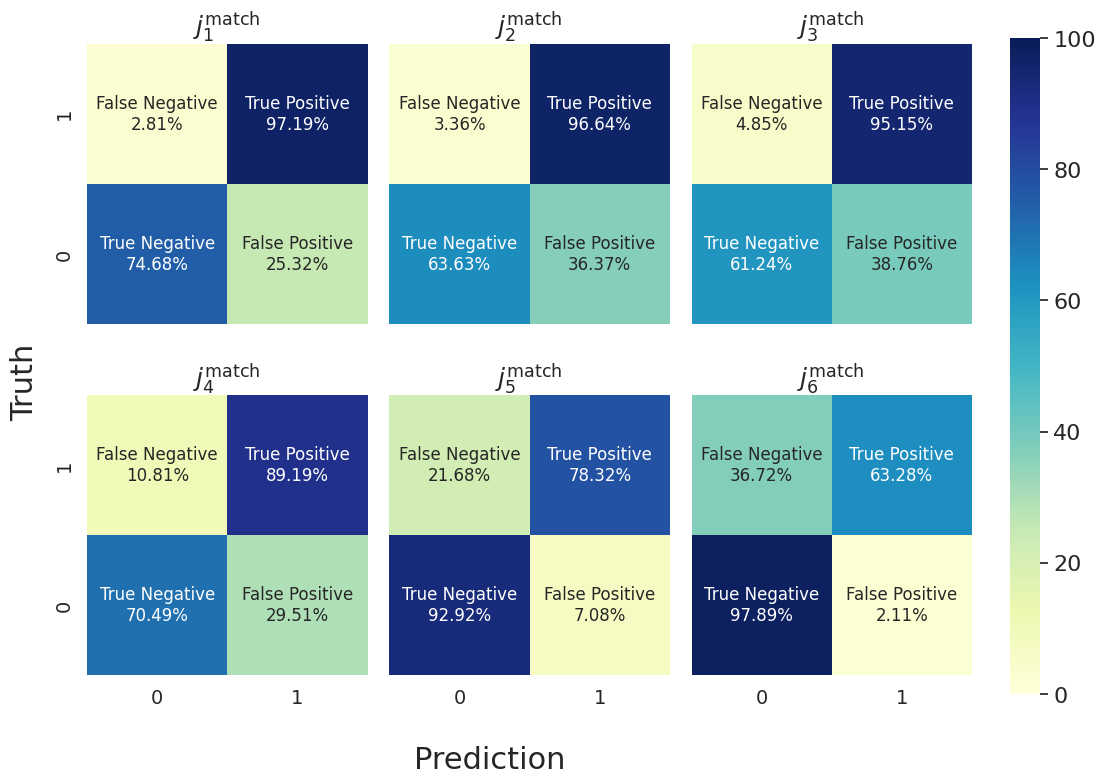

In [20]:
%matplotlib inline
cms = multilabel_confusion_matrix(np.array(true_scaled), np.array(jet_preds_scaled).round())
print(cms)

fig, ax = plt.subplots(2,3, sharex=True, sharey=True, figsize=(10, 8))
cbar_ax = fig.add_axes([1.02, .11, .03, .82])

jet = 0
for i in range(2):
    for j in range(3):
        cm = cms[jet]
        group_names = ['False Negative','True Positive','True Negative','False Positive']
        #group_counts = ["({0:0.0f} Events)".format(value) for value in cm.flatten()]
        group_percentages = ["{0:.2%}".format(value) for value in cm[1].flatten()/np.sum(cm[1])]
        group_percentages.extend(["{0:.2%}".format(value) for value in cm[0].flatten()/np.sum(cm[0])])
        #labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in zip(group_names,group_percentages, group_counts)]
        labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_percentages)]
        labels = np.asarray(labels).reshape(2,2)
        normed = [cm[1]*100/np.sum(cm[1]),cm[0]*100/np.sum(cm[0])]
        sub = sb.heatmap(normed,vmin=0, vmax=100, cmap='YlGnBu',fmt='',annot=labels, cbar=True, cbar_ax=cbar_ax,square=True, ax=ax[i,j])
        sb.set(font_scale=1)
        sub.figure.axes[-1].tick_params(labelsize=16)
        ax[i,j].set_title('$j_%d^{\mathrm{match}}$ '% (jet+1), fontsize=18)
        ax[i,j].tick_params(left=False,bottom=False, labelsize=14) 
        ax[i,j].set_xticklabels(['0','1'])
        ax[i,j].set_yticklabels(['1','0'])
        jet+=1
        #print('j'+str(jet+1)+' Accuracy: ',accuracy_score(true_unscaled[:,jet],predictions_unscaled.round()[:,jet]))
        #print('j'+str(jet+1)+' Precision: ',precision_score(true_unscaled[:,jet],predictions_unscaled.round()[:,jet]))


fig.supxlabel('Prediction',fontsize=22)
fig.supylabel('Truth',fontsize=22)
fig.tight_layout()

(array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

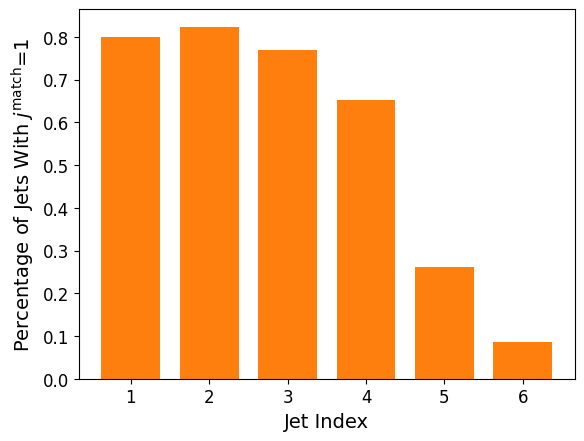

In [59]:
import matplotlib.pyplot as plt
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
%matplotlib inline
positives = [np.sum(cm[1])/(np.sum(cm[0])+np.sum(cm[1]))for cm in cms]
plt.bar(range(1,7), positives,width=0.75, color='tab:orange')
plt.grid(False)
plt.xticks(ticks=range(1,7),labels=[str(jet) for jet in range(1,7)])
plt.xlabel('Jet Index', fontsize=14)
plt.ylabel('Percentage of Jets With $j^{\mathrm{match}}$=1', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)


In [ ]:
print('j'+str(jet+1)+' Accuracy: ',accuracy_score(true_scaled[:,jet],jet_preds_scaled.round()[:,jet]))
print('j'+str(jet+1)+' Precision: ',precision_score(true_scaled[:,jet],jet_preds_scaled.round()[:,jet]))

In [54]:
a = [accuracy_score(true_scaled[:,jet],jet_preds_scaled.round()[:,jet]) for jet in range(6)]
p = [precision_score(true_scaled[:,jet],jet_preds_scaled.round()[:,jet]) for jet in range(6)]
df = pd.DataFrame({'Accuracies': a, 'Precisions': p}, index=['j'+str(i) for i in range(1,7)])
print(df)

    Accuracies  Precisions
j1    0.926703    0.938541
j2    0.908176    0.925430
j3    0.873117    0.890874
j4    0.827057    0.850537
j5    0.891077    0.796327
j6    0.949500    0.735651


In [56]:
print(df.to_latex())

\begin{tabular}{lrr}
\toprule
{} &  Accuracies &  Precisions \\
\midrule
j1 &    0.926703 &    0.938541 \\
j2 &    0.908176 &    0.925430 \\
j3 &    0.873117 &    0.890874 \\
j4 &    0.827057 &    0.850537 \\
j5 &    0.891077 &    0.796327 \\
j6 &    0.949500 &    0.735651 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_895090/2350534188.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(df.to_latex())
